#### 构建一个可迭代的类来模拟一个村庄中，农民与工匠间的贸易：

基本假设：村民们每天需要消耗1份粮食，农民花0.3天并消耗一份工具就能产出一份粮食，但缺乏工具时生产效率会降低，不消耗工具时手刨粮食需要0.8天产出一份(因此将农民生产每份工具的时间近似为0.5天，且农民每天消耗种地时间量的工具)；

农民生产粮食，工具的时间消耗为[0.3, 0.5]；

工匠生产粮食，工具的时间消耗为[0.7, 0.2]。

因此每个村民都具有如下属性：

  生产属性，通过生产单位产品所需的时间衡量；
  
  消耗属性，每日消耗的产品份数；
  
  生产耗时，在生产某种产品上消耗的时间；
  
  贸易量，各商品的卖出，买入份数；
  
  库存状态，每天的(生产-消耗+贸易)量将被加入其中。越缺乏某种产品，越有动力去通过工作或贸易获得之。
  
先考虑不含贸易的类:
每一位村民的初始库存全部为0，他每天消耗在某项产品上的工作时长 = -库存 × 0.1 × 生产效率，

因此村民的产品消耗量为[1,农产品工作时长]

商品定价：每次交易计算 供需比例=(供应-需求)/(供应+需求),下次价格为 价格×EXP(供需比例)

购买行为：得知自己的优势商品后，购买所有值得的不容忍量，并希望出售等价值的商品

In [3]:
# 均值化以观察图像
import numpy as np
def moving_average(lst, k=5):
    arr = np.array(lst, dtype=float)
    n = len(arr)
    half = k // 2
    
    # 先创建一个全为原始数据的结果数组
    result = arr.copy()

    # 只在能够滑动的位置做滑动均值
    for i in range(half, n - half):
        result[i] = np.mean(arr[i - half:i + half + 1])

    return result

# 画图预备包
import matplotlib.pyplot as plt
Names = ["A's ", "B's ", "C's "];
Goods = ["food", "tools", "clothes", "gold"];
def fun_fianl(status, x, i, j):
    return [status[y][i][j] for y in x]
def visual(status, worktimes, prices = 0, k=0, names = Names, goods = Goods):
    if prices == 0:
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    else:
        fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    x=range(0,len(status))
    for i in range(len(status[0])):
        for j in range(len(status[0][1])):
            ax[0].plot(x, fun_fianl(status, x,i,j),label = names[i] + goods[j])
    ax[0].set_xlabel('Day')
    ax[0].set_ylabel('SVGtatus')
    ax[0].legend(loc='best')
    ax[0].grid()
    y = np.array(list(map(lambda x: np.sum(x, axis=1),worktimes))).T
    for i in range(len(y)):
        ax[1].plot(range(0,len(y[0])),moving_average(y[i], k), label = names[i])
    ax[1].set_xlabel('Day')
    ax[1].set_ylabel('Work Time')
    ax[1].legend(loc='best')
    ax[1].grid()
    if prices != 0:
        z = np.array(prices).T
        z = z / z[0] # 归一化以观察价格比例
        for i in range(len(z)):
            ax[2].plot(range(0,len(z[0])),z[i], label = goods[i])
            ax[2].set_xlabel('Day')
            ax[2].set_ylabel('Goods Prices')
            ax[2].legend(loc='best')
            ax[2].grid()

In [4]:
import numpy as np
import copy
class IsoBlock(object): 
    def __init__(self, consumption, product_eff, status):
        """
        经济模拟系统中的独立无交易区块类。
        """
        # 读取参数，状态和工作时间
        self.consumption = np.array( consumption, dtype=float)  # 商品消耗量
        self.product_eff = np.array(product_eff, dtype=float)  # 单位时间能生产的商品量
        self.product_time = 1 / self.product_eff # 生产单位商品所需时间
        self.status = np.array(status, dtype=float)  # 库存状态
    
    def evolution(self, day):
        """
        经济演化过程。
        
        """
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度（即1/5的工作时间，以保证库存在-5时单人独自能达到平衡））
#         self.worktime = (-self.status * 0.2) * self.product_time
#         self.worktime[self.worktime < 0] = 0
        self.coef = np.log(self.product_time) * (self.product_time) / day
        self.worktime = np.exp(self.coef * self.status)
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime * self.product_eff
        
        # 计算每日非必须品消耗（工具消耗即工作时间）
#         self.consumption[:,1] = production[:,0]
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption

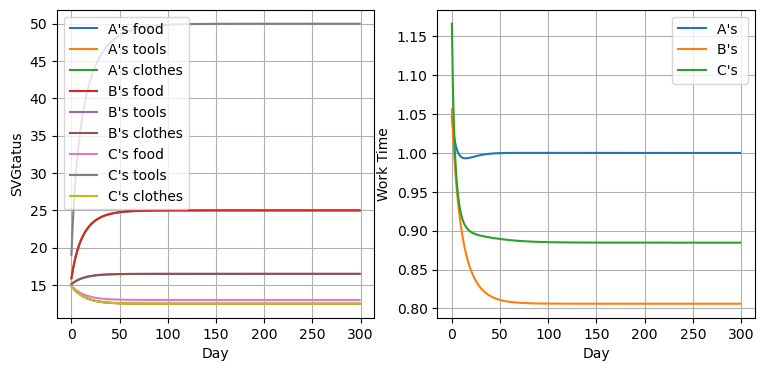

In [5]:
# 创建实例
j=3; k=3;
Status = [];
Worktimes = [];
test = IsoBlock( 
               np.ones([j,k]), #201,纺 农 匠
               [[2.5, 2.5, 5],[5, 3.3, 3.3], [2.6, 10, 2.5]], 
               np.ones([j,k]) * 15)
for i in range(300):
    test.evolution(5)
    Status.append(test.status)
    Worktimes.append(test.worktime),test
visual(Status, Worktimes)

粮食价格较低，工具价格适中，衣服价格较高，
造成粮食求过于供，工具刚好平衡，衣服供过于求.
既需要生产截断阻止能买到的商品的再生产，又需要放大购买欲望，超过需求量，以达到提高库存压缩购买欲望的目的

In [51]:
import numpy as np
from collections import Counter
class TradeBlock(IsoBlock): 
    def __init__(self, consumption, product_time, status, currency, trade_prices):
        """
        经济模拟系统中的有贸易区块类。
        """
        # 读取参数，状态和工作时间
        super().__init__(consumption, product_time, status)
        self.currency = np.array(currency, dtype=float) # 各职业手中的资产
        self.trade_prices = np.array(trade_prices, dtype=float) # 商品的市场价格
        # 给出演化中不变但需要用到的常参数
        self.category = len(trade_prices) # 商品种数
        self.N = len(status) # 职业数
        self.x = range(self.N)
        self.swift = []
        self.voidm = np.zeros_like(self.status)
        
        self.preworktime = 0 #初始化抑制参数
    
    def evolution(self, day, reaction, test): 
        # day: 仓储容量，day = 10即有能用10天的货物; 
        # reaction: 工作时间的更新比例;
        # test: 是否实装价格变化
        """
        经济演化过程。
        
        """
        # 计算各职业的体感价格(生产某商品时赚取单位价值所需的时间，并倾向于生产效率最高的产品)
        self.feel_price = self.product_eff * self.trade_prices
        # 找到对某职业相对最优势的商品序号
        self.choice = np.array(np.argmax(self.feel_price, axis=1),dtype=int)
        
        #计算各职业每日拟购买的各商品量
        self.needs = np.exp(-self.status / day + 1) #购买所有商品,库存越多想买的越少，平衡于仓储容量
        self.needs[range(self.N), self.choice] = 0 #但不买自身的优势商品
        #对所有职业求和得到各商品量的需求量
        self.need = np.sum(self.needs, axis=0)
        #计算在市场上拟支出的金额（商品消耗量 × 商品价值）
        self.expend = self.needs * self.trade_prices
        #计算在市场上拟出售的(优势)商品数量
        self.sell = np.sum(self.expend, axis=1) / self.trade_prices[self.choice]
        #计算各商品的供应量
        self.provide = np.zeros(self.category)
        np.add.at(self.provide, self.choice, self.sell) #找出某职业售卖量（sell）的商品种类（choice）
        
#         # 各职业被满足的需求量
#         self.filled = self.provide + 0 # +0以免干扰原指标
#         self.filled[self.filled > self.need] = self.need[self.filled > self.need] # 削去过量供给
#         # 各职业卖出的商品量
#         self.presold = self.need + 0 # +0以免干扰原指标
#         self.presold[self.presold > self.provide] = self.provide[self.presold > self.provide] # 削去过量需求
#         self.sold = np.zeros_like(self.status) 
#         self.sold[np.arange(len(self.choice)), self.choice] = self.presold[self.choice] #将售卖量放入状态（status）中
# 上述做法不行，直接削除无法分配供给
        # 供需比例
        self.ndp = np.ones(self.category)
        self.ndp[self.need != 0] = self.provide[self.need != 0] / self.need[self.need != 0]
        self.ndp[self.ndp > 1] = 1 #削去过量供应
        # 各职业被满足的需求量
        self.filled = self.needs * self.ndp #以计算真实的购买量
        # 需供比例
        self.pdn = np.ones(self.category)
        self.pdn[self.provide != 0] = self.need[self.provide != 0] / self.provide[self.provide != 0]
        self.pdn[self.pdn > 1] = 1 #削去过量需求
        # 各职业卖出的商品量。共卖同一种商品时平分市场
        count = Counter(self.choice)
        temp = np.zeros(self.N)
        for num in self.choice:
            temp[num] = 1 / count[num]
        self.presold = self.provide * self.pdn * temp #以计算真实的出售量
        self.sold = np.zeros_like(self.status) 
        self.sold[np.arange(len(self.choice)), self.choice] = self.presold[self.choice] #将售卖量放入状态（status）中
        
        # 计算每日工作时间
        self.worktime = (1 - self.status * 2 / day) * self.product_time #存货不到仓储容量的一半时开始自己动手生产
        self.worktime[self.worktime < 0] = 0 #仓储够时不生产
        coef = np.log(self.product_time[self.x, self.choice]) * (self.product_time[self.x, self.choice]) / day
        self.worktime[self.x, self.choice] = np.exp(coef * self.status[self.x, self.choice])
        self.worktime = (self.worktime * reaction + self.preworktime * (1-reaction))
        self.worktime[self.worktime < 0.01] = 0
        self.preworktime = self.worktime
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime * self.product_eff
        
        # 计算每日非必须品消耗（工具消耗即工作时间） 
#         self.consumption[:,1] = production[:,0] #由于种田消耗工具将导致种田成本变化，影响优势商品的选取，故先不实装以测试平衡
        
        # 计算总劳动负担（每个职业的工作时间总和）
        loading = np.sum(self.worktime, axis=1)
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption
        if test == 0:
            self.status_test =  self.status + self.filled - self.sold
        else:
            self.status = self.status + self.filled - self.sold
        # 计算货币流动
#         print(self.sold,self.filled)
        self.exchange = np.sum((self.sold - self.filled)  * self.trade_prices, axis=1)
#         print(self.currency, self.exchange)
        self.currency += self.exchange
#         self.swift.append([self.exchange+0, self.currency+0])
        
        # 加权供需比例作为调整价格的基数
        self.change = (self.need - self.provide) / (self.need + self.provide)
        if test == 0:
            self.trade_test = self.trade_prices * np.exp(self.change * 0.2)
        else:
            self.trade_prices = self.trade_prices * np.exp(self.change * 0.02)

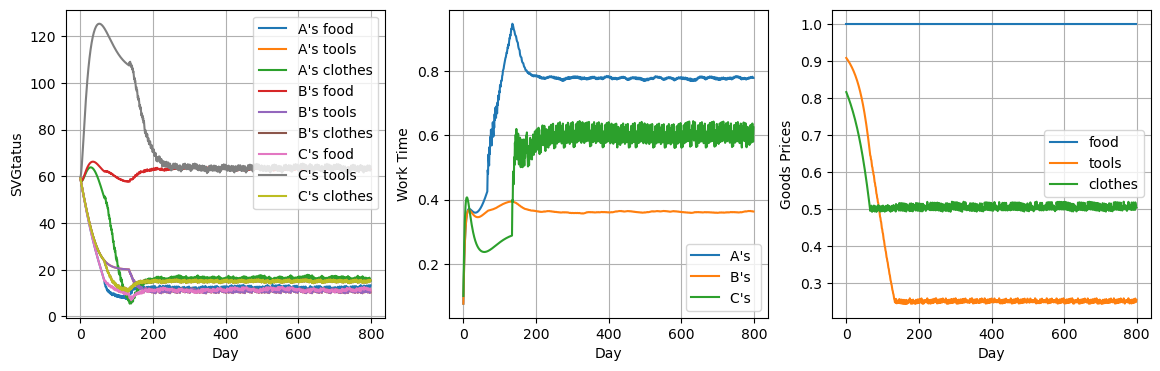

In [52]:
# 创建实例
j=3; k=3;
Status = [];
Worktimes = [];
Prices = [];
test = TradeBlock( 
               np.ones([j,k]), #201,纺 农 匠
               [[2.5, 2.5, 5],[5, 3.3, 3.3], [2.5, 10, 3]], 
#                [[2,2,7],[7,2,2],[2,7,2]],
               np.ones([j,k]) * 60, 
               np.zeros(j),
               [1.1,1,0.9])
for i in range(800):
    test.evolution(20, 0.2, 1)
    Status.append(test.status)
    Worktimes.append(test.worktime)
    Prices.append(test.trade_prices)
visual(Status, Worktimes, Prices, 0)

### 最大缺陷：对于初始价格敏感，因为其决定了供需关系，进而影响后续价格。因此必须加入职业转换与合作价格来修正贸易

In [54]:
sum(test.currency)

0.0

In [53]:
# 参数检查
for attr, value in vars(test).items():
    print(f"{attr} = {value}")

consumption = [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
product_eff = [[ 2.5  2.5  5. ]
 [ 5.   3.3  3.3]
 [ 2.5 10.   3. ]]
product_time = [[0.4        0.4        0.2       ]
 [0.2        0.3030303  0.3030303 ]
 [0.4        0.1        0.33333333]]
status = [[13.31651982 10.32150488 15.24118189]
 [63.06262779 10.32150488 15.54616487]
 [11.14539941 64.09122512 15.54616487]]
currency = [ 547.29063006  122.69380621 -669.98443626]
trade_prices = [6.26879129 1.60046934 3.16234929]
category = 3
N = 3
x = range(0, 3)
swift = []
voidm = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
preworktime = [[0.12132824 0.         0.65650427]
 [0.36268243 0.         0.        ]
 [0.35932325 0.26496322 0.        ]]
feel_price = [[15.6964215   3.92194481 15.86827358]
 [31.39284301  5.17696714 10.47306056]
 [15.6964215  15.68777923  9.52096415]]
choice = [2 0 0]
needs = [[1.45043231 1.54330274 0.        ]
 [0.         1.54330274 1.26617495]
 [0.         0.11978226 1.26617495]]
need = [1.45043231 3.20638774 2.5323499 ]
exp